In [2]:
# =====================================
# Basic Settings & Utilities
# =====================================
import warnings
import joblib
import numpy as np
import pandas as pd

# =====================================
# Visualization
# =====================================
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

# =====================================
# Data Preprocessing & Dimensionality Reduction
# =====================================
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import zscore

# =====================================
# Regression Models & Statistical Analysis
# =====================================
import statsmodels.api as sm
from statsmodels.api import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.nonparametric.smoothers_lowess import lowess
from patsy import dmatrix
from linearmodels.panel import PanelOLS

# Support for Japanese fonts
plt.rcParams['font.family'] = 'IPAexGothic'
plt.rcParams['axes.unicode_minus'] = False

# Ensure reproducibility
import random
random.seed(42)
np.random.seed(42)


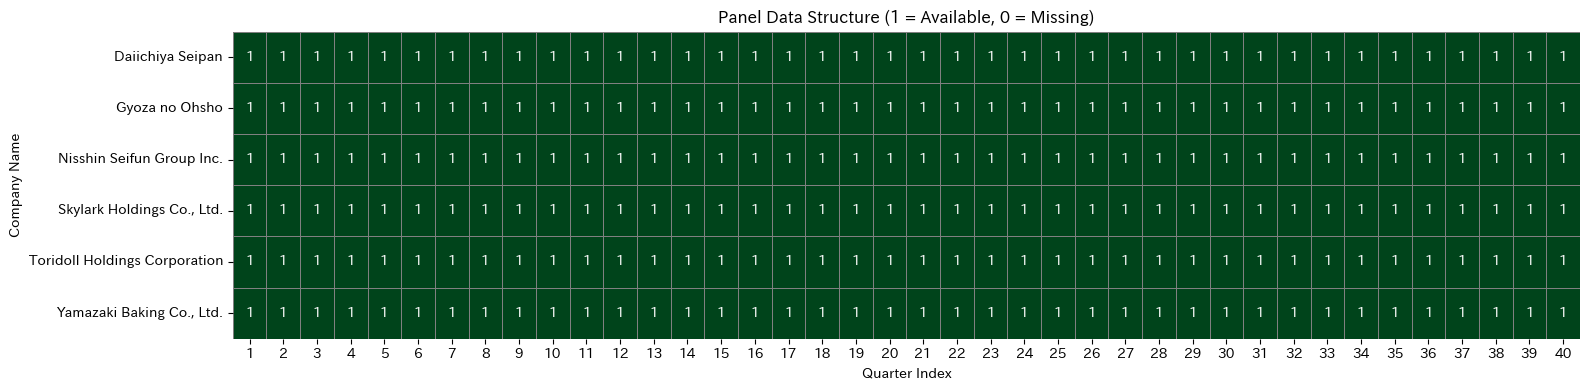

In [3]:
# ======================================================
# 0. Load and preprocess data (Excel → DataFrame)
# ======================================================

# --- Load Excel file using openpyxl engine ---
df = pd.read_excel("panel_data.xlsx", engine="openpyxl")

# --- Trim whitespace from column names ---
df.columns = df.columns.str.strip()

# --- Trim whitespace from company names to avoid inconsistencies ---
df["Company Name"] = df["Company Name"].astype(str).str.strip()

# --- Convert quarter strings ("Q1"–"Q4") to integers (1–4) ---
df["Quarter"] = df["Quarter"].replace({"Q1": 1, "Q2": 2, "Q3": 3, "Q4": 4})

# --- Create unique time index (e.g., 2015 Q1 → 0) ---
df["Quarter_Index"] = (df["Year"].astype(int) - 2015) * 4 + df["Quarter"].astype(int)

# --- Save the processed DataFrame to Excel for documentation ---
df.to_excel("output_processed_panel_data.xlsx", index=False)

# ======================================================
# Visualize panel data coverage (missing vs. observed)
# ======================================================

# Create a pivot table: 1 = observed, 0 = missing
coverage = (
    df.pivot_table(
        index="Company Name",
        columns="Quarter_Index",
        values="Gross Profit Margin",
        aggfunc=lambda x: 1 if x.notnull().any() else 0,
        fill_value=0
    )
)

plt.figure(figsize=(16, 4))  # Wider layout to accommodate many quarters

sns.heatmap(
    coverage,                # Matrix: Company × Quarter Index
    cmap="Greens",           # Green color scale for clarity
    cbar=False,              # Hide color bar
    linewidths=0.5,          # Cell border thickness
    linecolor='gray',        # Border color
    vmin=0, vmax=1,          # Color scale (0 = missing, 1 = present)
    annot=True, fmt="d"      # Show 0 or 1 in each cell
)

# --- Set title and axis labels ---
plt.title("Panel Data Structure (1 = Available, 0 = Missing)")
plt.xlabel("Quarter Index")
plt.ylabel("Company Name")
plt.tight_layout()

# --- Save the plot as PNG ---
plt.savefig("output_panel_data_coverage_heatmap.png", dpi=300)

# --- Show the plot ---
plt.show()


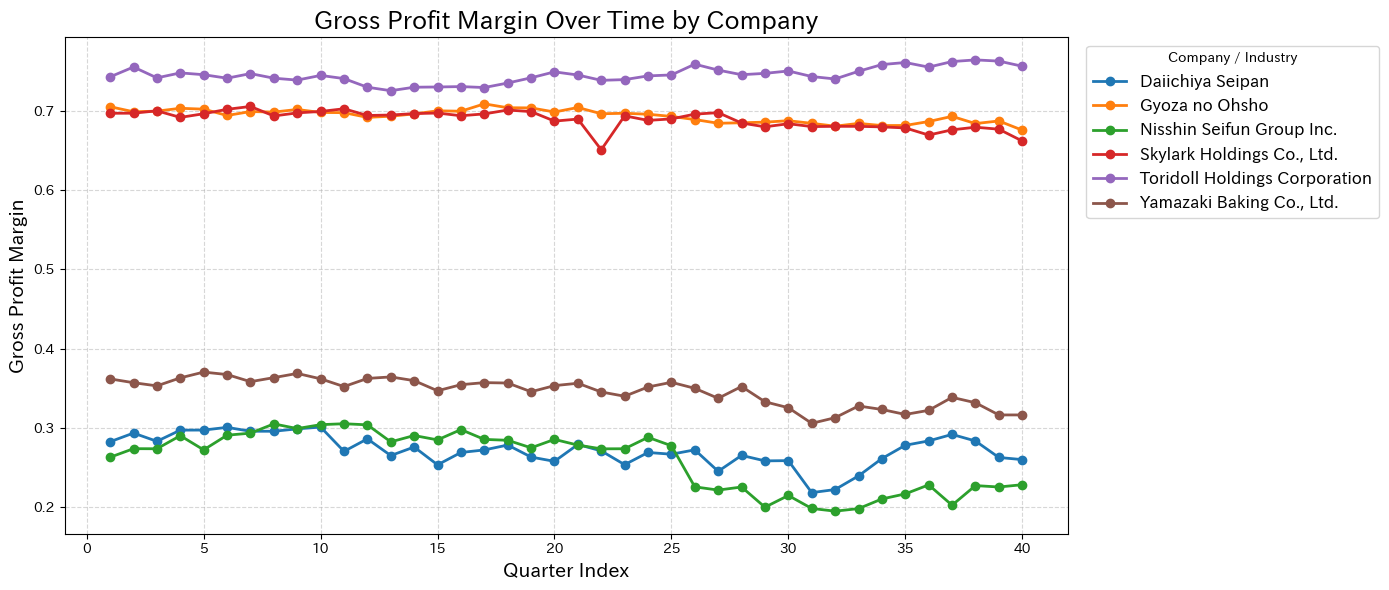

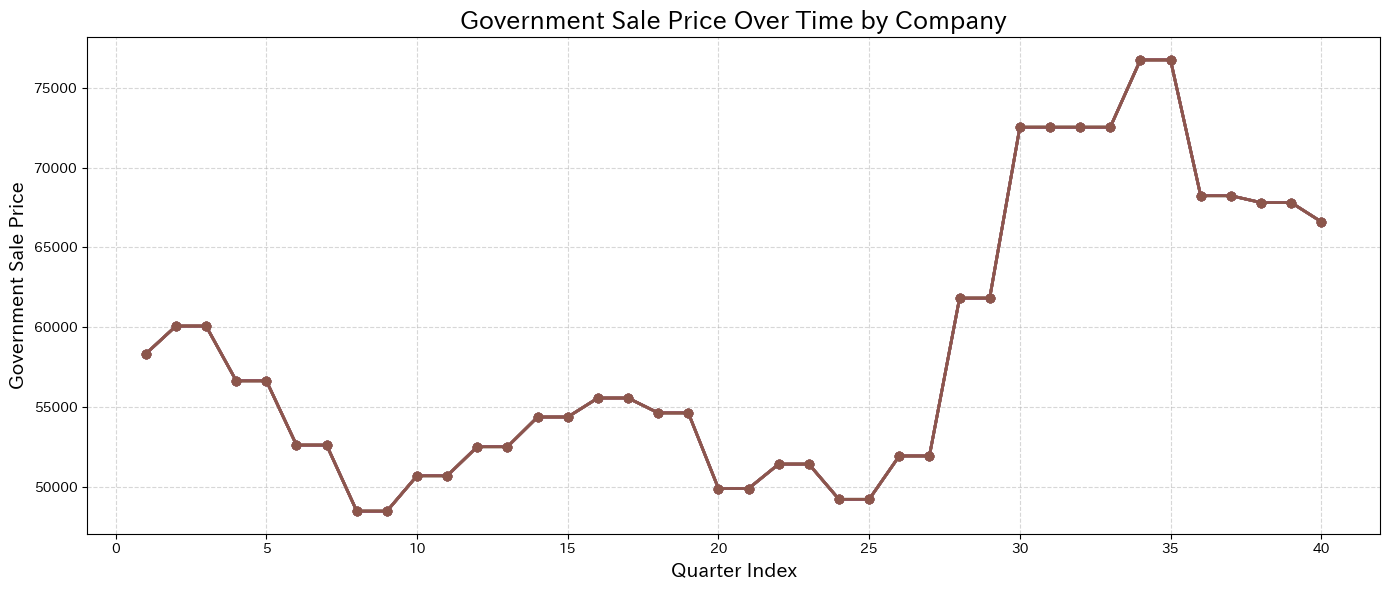

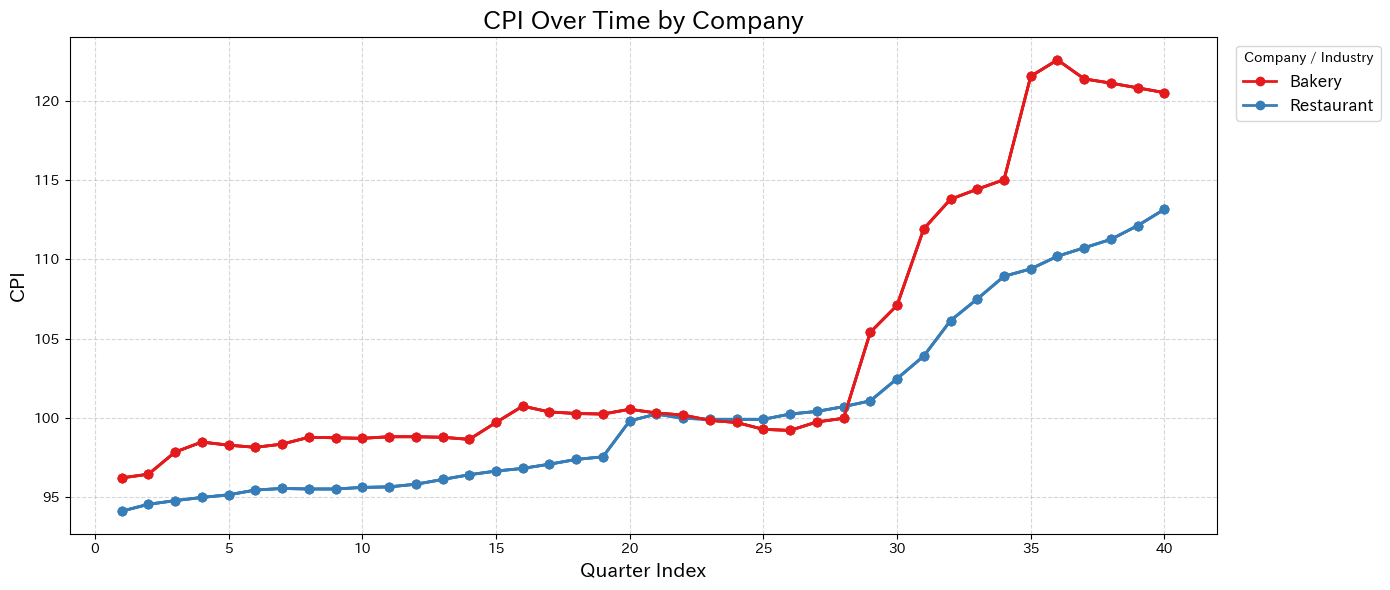

In [4]:
# ======================================================
# 1. Visualize Data Structure (Time Series by Company)
# ======================================================

import matplotlib.pyplot as plt
import seaborn as sns

# Get unique company names
# → Used for assigning colors in the palette
# Example: ["Yamazaki Baking", "Nisshin Seifun Group", ...]
df_companies = df['Company Name'].unique()
palette = sns.color_palette('tab10', n_colors=len(df_companies))

# Custom color map for CPI:
# Bakeries (Industry Dummy = 0) → red, Restaurants (Dummy = 1) → blue
cpi_palette = sns.color_palette('Set1', n_colors=2)
cpi_color_map = {0: cpi_palette[0], 1: cpi_palette[1]}

# Target variables to visualize
target_vars = ['Gross Profit Margin', 'Government Sale Price', 'CPI']

for var in target_vars:
    plt.figure(figsize=(14, 6))
    seen_labels = set()  # Avoid duplicate labels in CPI legend

    for idx, (company, group) in enumerate(df.groupby('Company Name')):
        x = group['Quarter_Index']
        y = group[var]

        # --- Set label and line color ---
        if var == 'Government Sale Price':
            label = None
            color = palette[idx]
        elif var == 'CPI':
            industry = group['Industry Dummy'].iloc[0]
            label = 'Bakery' if industry == 0 else 'Restaurant'
            if label in seen_labels:
                label = None
            else:
                seen_labels.add(label)
            color = cpi_color_map[industry]
        else:
            label = company
            color = palette[idx]

        # --- Plot ---
        plt.plot(
            x, y,
            marker='o',
            label=label,
            linewidth=2,
            color=color
        )

    # --- Plot settings ---
    plt.title(f"{var} Over Time by Company", fontsize=18)
    plt.xlabel("Quarter Index", fontsize=14)
    plt.ylabel(var, fontsize=14)

    if var != 'Government Sale Price':
        plt.legend(title="Company / Industry", bbox_to_anchor=(1.01, 1), loc="upper left", fontsize=12)

    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(f"output_{var.replace(' ', '_')}_by_company_timeseries.png", dpi=300)
    plt.show()



In [5]:
# ======================================================
# 2. Multicollinearity Check (VIF: Variance Inflation Factor)
# ======================================================

# --- Extract explanatory variables and drop missing values ---
# Check for multicollinearity between "Government Sale Price" and "CPI"
vif_df = df[["Government Sale Price", "CPI"]].dropna()

# --- Add constant term (intercept) ---
# Required to properly estimate the bias in regression models
X = sm.add_constant(vif_df)

# --- Calculate VIF for each variable ---
# VIF > 5 indicates moderate, >10 indicates high multicollinearity
vif_result = pd.DataFrame({
    "Variable": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

# --- Display the result ---
print("=== Multicollinearity Check (VIF) ===")
print(vif_result)

# --- Save the result as CSV for documentation/reporting ---
vif_result.to_csv("output_VIF_results.csv", index=False)


=== Multicollinearity Check (VIF) ===
                Variable         VIF
0                  const  216.166723
1  Government Sale Price    2.323450
2                    CPI    2.323450


# 2. Multicollinearity Check (VIF) Results
- **No concern of multicollinearity between Government Sale Price and CPI**
- Validated the justification for including these two variables as explanatory variables in the modl


=== R² by Lag Combination (Descending) ===
    Gov_Lag  CPI_Lag        R2  Gov_PValue  CPI_PValue
20        4        0  0.372533    0.001015    0.000543
15        3        0  0.327644    0.000704    0.000380
21        4        1  0.306529    0.001966    0.000779
0         0        0  0.295272    0.175975    0.006861
10        2        0  0.283262    0.000002    0.000582
1         0        1  0.275575    0.092394    0.043767
5         1        0  0.275512    0.464373    0.006454
2         0        2  0.267761    0.052276    0.164244
3         0        3  0.263046    0.036217    0.368493
4         0        4  0.262220    0.027505    0.600185
16        3        1  0.255579    0.000342    0.000291
6         1        1  0.247917    0.155847    0.022586
22        4        2  0.245074    0.001974    0.000763
7         1        2  0.232323    0.074938    0.096581
9         1        4  0.226853    0.029959    0.608604
11        2        1  0.225884    0.125205    0.000747
8         1        3  

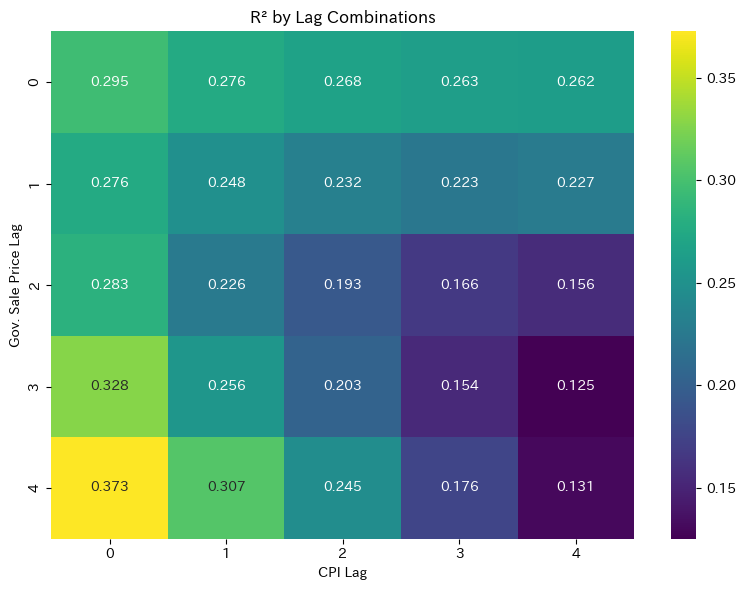

In [7]:
# ======================================================
# 3. Identify Optimal Lags: Government Price × CPI
# ======================================================

# --- Define lag candidates (0 to 4 quarters) ---
lags = [0, 1, 2, 3, 4]
results = []

# --- Iterate over all lag combinations (5 × 5 = 25) ---
for gov_lag in lags:

    # --- Create lagged column for Government Sale Price (per company) ---
    col_gov = f"GovPrice_lag{gov_lag}"
    if gov_lag == 0:
        df[col_gov] = df["Government Sale Price"]
    else:
        df[col_gov] = df.groupby("Company Name")["Government Sale Price"].shift(gov_lag)

    for cpi_lag in lags:
        col_cpi = f"CPI_lag{cpi_lag}"
        if cpi_lag == 0:
            df[col_cpi] = df["CPI"]
        else:
            df[col_cpi] = df.groupby("Company Name")["CPI"].shift(cpi_lag)

        # --- Prepare panel data (drop NA & set index) ---
        panel = df[[
            "Gross Profit Margin",
            col_gov,
            col_cpi,
            "Company Name",
            "Quarter_Index"
        ]].dropna().set_index(["Company Name", "Quarter_Index"])

        if panel.empty:
            continue  # Skip if no valid data

        # --- Build PanelOLS model with entity fixed effects ---
        formula = f"`Gross Profit Margin` ~ `{col_gov}` + `{col_cpi}` + EntityEffects"
        model = PanelOLS.from_formula(
            formula,
            data=panel,
            check_rank=False
        )
        res = model.fit(cov_type="clustered", cluster_entity=True)

        # --- Save R² and p-values for both predictors ---
        results.append({
            "Gov_Lag": gov_lag,
            "CPI_Lag": cpi_lag,
            "R2": res.rsquared,
            "Gov_PValue": res.pvalues.get(col_gov, None),
            "CPI_PValue": res.pvalues.get(col_cpi, None)
        })

# ======================================================
# 3-1. Format and Export Results
# ======================================================

# --- Convert to DataFrame and sort by R² ---
results_df = pd.DataFrame(results)
print("=== R² by Lag Combination (Descending) ===")
print(results_df.sort_values("R2", ascending=False))

# --- Save result to CSV for reference ---
results_df.to_csv("output_lag_combination_R2_list.csv", index=False)

# --- Visualize R² heatmap by lag combinations ---
pivot_r2 = results_df.pivot(index="Gov_Lag", columns="CPI_Lag", values="R2")
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_r2, annot=True, fmt=".3f", cmap="viridis")
plt.title("R² by Lag Combinations")
plt.xlabel("CPI Lag")
plt.ylabel("Gov. Sale Price Lag")
plt.tight_layout()

# --- Save heatmap as PNG ---
plt.savefig("output_lag_combination_R2_heatmap.png", dpi=300)
plt.show()


# 3. Identify Optimal Lags: Government Price × CPI
- The most explanatory lags are **lag 4 for Government Sale Price and lag 0 for CPI*



===== [Bakery] spline(df=3) + fixed lags gov=4, cpi=0 =====
                           PanelOLS Estimation Summary                           
Dep. Variable:     Gross Profit Margin   R-squared:                        0.7938
Estimator:                    PanelOLS   R-squared (Between):              0.9932
No. Observations:                  108   R-squared (Within):               0.7938
Date:                 Wed, Jun 11 2025   R-squared (Overall):              0.9280
Time:                         05:12:21   Log-likelihood                    322.84
Cov. Estimator:         Driscoll-Kraay                                           
                                         F-statistic:                      76.998
Entities:                            3   P-value                           0.0000
Avg Obs:                        36.000   Distribution:                   F(5,100)
Min Obs:                        36.000                                           
Max Obs:                        36.00

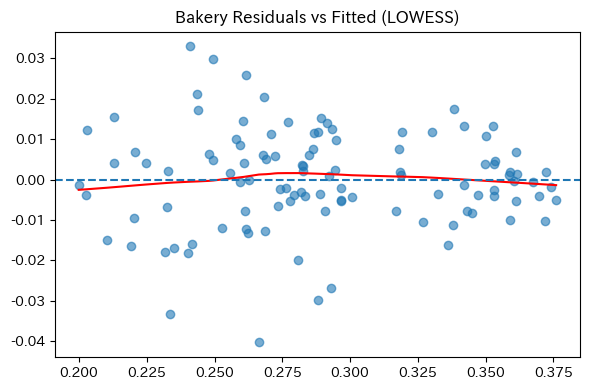

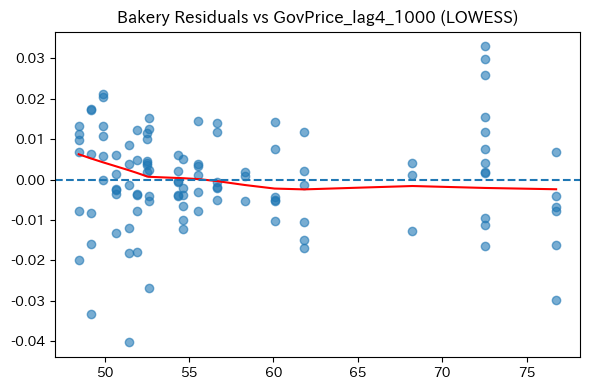

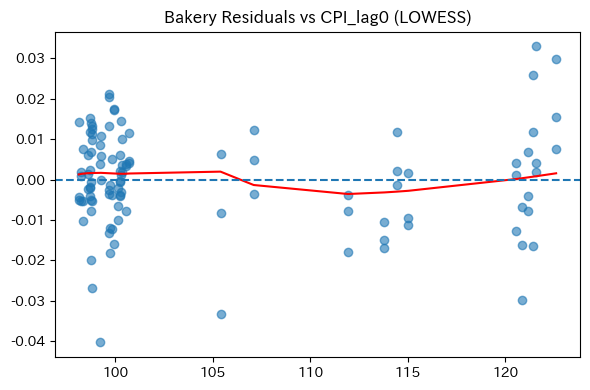

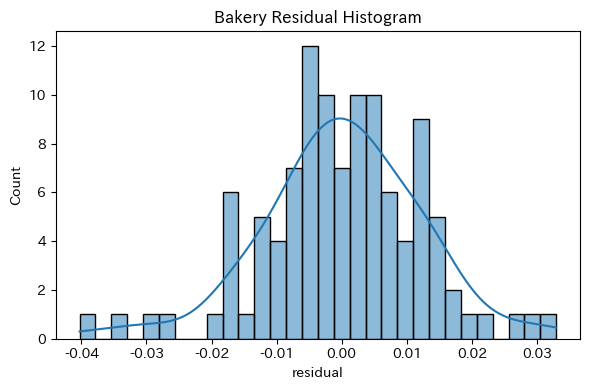

<Figure size 600x300 with 0 Axes>

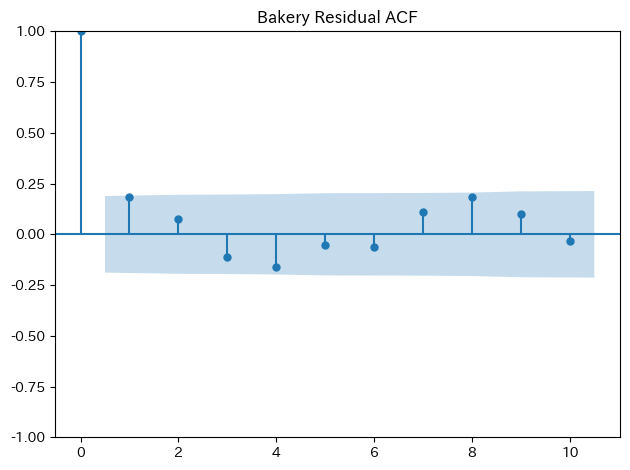


===== [Restaurant] spline(df=3) + fixed lags gov=4, cpi=0 =====
                           PanelOLS Estimation Summary                           
Dep. Variable:     Gross Profit Margin   R-squared:                        0.5218
Estimator:                    PanelOLS   R-squared (Between):              0.9965
No. Observations:                  108   R-squared (Within):               0.5218
Date:                 Wed, Jun 11 2025   R-squared (Overall):              0.9327
Time:                         05:12:24   Log-likelihood                    382.25
Cov. Estimator:         Driscoll-Kraay                                           
                                         F-statistic:                      21.825
Entities:                            3   P-value                           0.0000
Avg Obs:                        36.000   Distribution:                   F(5,100)
Min Obs:                        36.000                                           
Max Obs:                        3

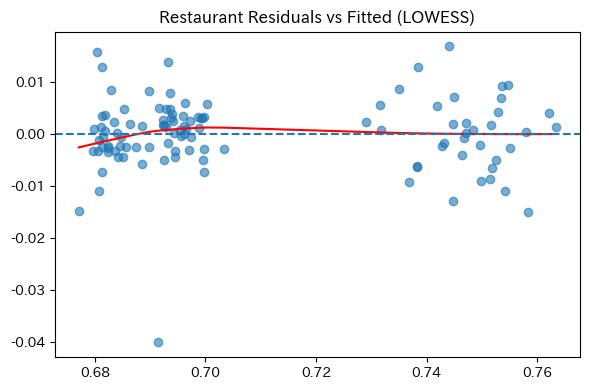

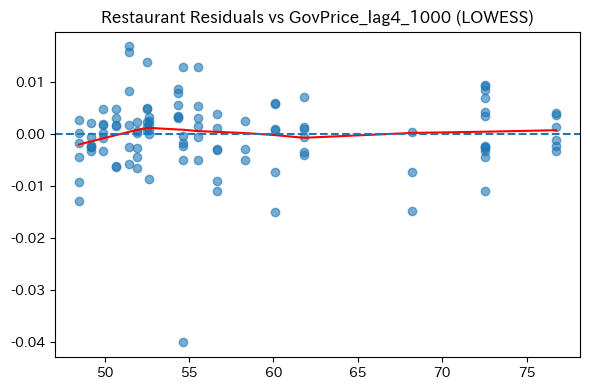

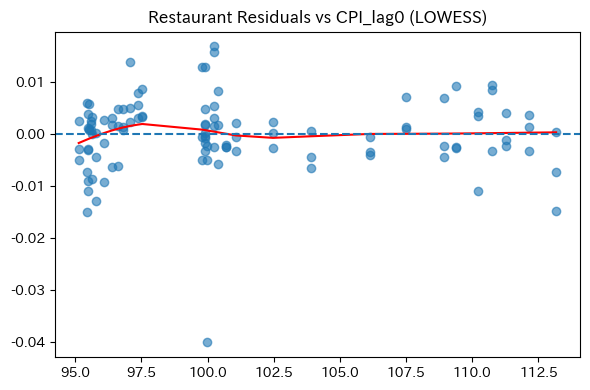

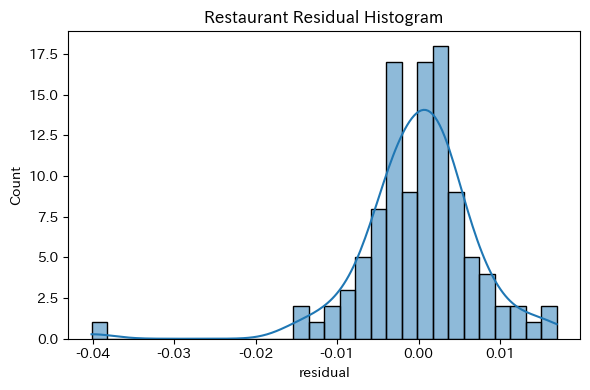

<Figure size 600x300 with 0 Axes>

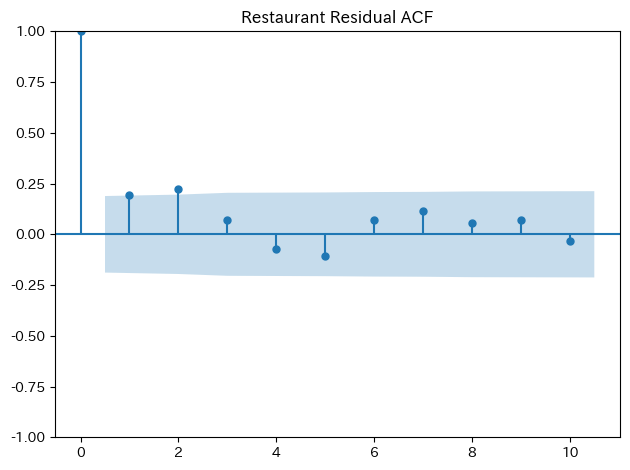

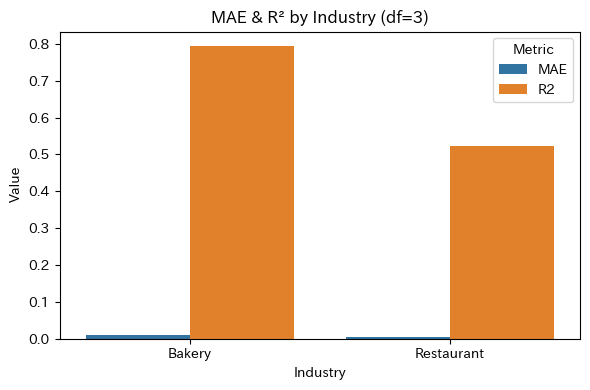

Saved industry_metrics.csv
Saved model_summaries.pkl


In [10]:
# ======================================================
# 4. Main Model: Panel Regression with Spline(df=3) on AR Component 1
# ======================================================

warnings.filterwarnings("ignore", category=RuntimeWarning, module="statsmodels")

# --- Map industry: Bakery = 0, Restaurant = 1 ---
industry_map = {
    "Yamazaki Baking Co., Ltd.": 0, "Daiichiya Seipan": 0, "Nisshin Seifun Group Inc.": 0,
    "Gyoza no Ohsho": 1, "Toridoll Holdings Corporation": 1, "Skylark Holdings Co., Ltd.": 1
}
df["Industry"] = df["Company Name"].map(industry_map)

metrics = []
best_model_summaries = {}

gov_lag = 4
cpi_lag = 0

for sector_name, sector_val in {"Bakery": 0, "Restaurant": 1}.items():
    print(f"\n===== [{sector_name}] spline(df=3) + fixed lags gov={gov_lag}, cpi={cpi_lag} =====")
    df_sector = df[df["Industry"] == sector_val].copy()

    df_sector["GPM_lag1"] = df_sector.groupby("Company Name")["Gross Profit Margin"].shift(1)
    df_sector["GPM_lag4"] = df_sector.groupby("Company Name")["Gross Profit Margin"].shift(4)
    df_sector[f"GovPrice_lag{gov_lag}_1000"] = df_sector.groupby("Company Name")["Government Sale Price"].shift(gov_lag) / 1000
    df_sector[f"CPI_lag{cpi_lag}"] = df_sector.groupby("Company Name")["CPI"].shift(cpi_lag)

    valid_idx = df_sector.dropna(subset=["GPM_lag1", "GPM_lag4"]).index
    if valid_idx.empty:
        print("Insufficient data, skipping.")
        continue

    ar_std = StandardScaler().fit_transform(df_sector.loc[valid_idx, ["GPM_lag1", "GPM_lag4"]])
    ar_pca = PCA(n_components=2).fit_transform(ar_std)
    df_sector.loc[valid_idx, "AR_comp1"] = ar_pca[:, 0]

    df_valid = df_sector.loc[valid_idx].copy()
    spline_basis = dmatrix("bs(AR_comp1, df=3, include_intercept=False)", data=df_valid, return_type="dataframe")
    spline_basis.columns = [f"AR_spline{i+1}" for i in range(spline_basis.shape[1])]
    spline_basis.index = valid_idx
    df_spline = pd.concat([df_valid, spline_basis], axis=1)

    predictors = list(spline_basis.columns) + [f"GovPrice_lag{gov_lag}_1000", f"CPI_lag{cpi_lag}"]

    panel = df_spline[["Gross Profit Margin"] + predictors + ["Company Name", "Quarter_Index"]].dropna()
    if panel.empty:
        print("No data for model, skipping.")
        continue

    panel = panel.set_index(["Company Name", "Quarter_Index"])

    model = PanelOLS.from_formula(f"`Gross Profit Margin` ~ {' + '.join(f'`{p}`' for p in predictors)} + EntityEffects", panel, check_rank=False)

    try:
        res = model.fit(cov_type="driscoll-kraay")
    except ZeroDivisionError:
        print(f"[Warning] Model for {sector_name} failed due to zero degrees of freedom. Skipping...")
        continue

    print(res.summary)
    best_model_summaries[sector_name] = res.summary.as_text()
    with open(f"{sector_name}_summary.txt", 'w', encoding='utf-8') as f:
        f.write(best_model_summaries[sector_name])

    actual = panel["Gross Profit Margin"]
    fitted = res.fitted_values.squeeze()
    mae = np.mean(np.abs(actual - fitted))
    r2 = res.rsquared
    dw = durbin_watson(res.resids.squeeze())
    lb_p = acorr_ljungbox(res.resids.squeeze(), lags=[10], return_df=True)["lb_pvalue"].iloc[0]
    print(f"MAE: {mae:.6f} | R²: {r2:.4f} | DW: {dw:.3f} | LB p={lb_p:.4f}")
    metrics.append({"Industry": sector_name, "MAE": mae, "R2": r2})

    vif_X = panel[predictors].copy()
    vif_X = sm.add_constant(vif_X, has_constant="add")
    vif_df = pd.DataFrame({"Variable": vif_X.columns, "VIF": [variance_inflation_factor(vif_X.values, i) for i in range(vif_X.shape[1])]})
    vif_df = vif_df[vif_df["Variable"] != "const"]
    print("\n[VIF]")
    print(vif_df)

    residuals = res.resids.squeeze()

    plt.figure(figsize=(6, 4))
    lw = lowess(residuals, fitted)
    plt.scatter(fitted, residuals, alpha=0.6)
    plt.plot(lw[:, 0], lw[:, 1], color="red")
    plt.axhline(0, linestyle="--")
    plt.title(f"{sector_name} Residuals vs Fitted (LOWESS)")
    plt.tight_layout()
    plt.savefig(f"{sector_name}_residuals_vs_fitted_LOWESS.png", dpi=300)
    plt.show()
    plt.close()

    for pred in [f"GovPrice_lag{gov_lag}_1000", f"CPI_lag{cpi_lag}"]:
        plt.figure(figsize=(6, 4))
        lw = lowess(residuals, panel[pred])
        plt.scatter(panel[pred], residuals, alpha=0.6)
        plt.plot(lw[:, 0], lw[:, 1], color="red")
        plt.axhline(0, linestyle="--")
        plt.title(f"{sector_name} Residuals vs {pred} (LOWESS)")
        plt.tight_layout()
        plt.savefig(f"{sector_name}_residuals_vs_{pred}_LOWESS.png", dpi=300)
        plt.show()
        plt.close()

    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, bins=30, kde=True)
    plt.title(f"{sector_name} Residual Histogram")
    plt.tight_layout()
    plt.savefig(f"{sector_name}_residual_histogram.png", dpi=300)
    plt.show()
    plt.close()

    plt.figure(figsize=(6, 3))
    plot_acf(residuals, lags=10)
    plt.title(f"{sector_name} Residual ACF")
    plt.tight_layout()
    plt.savefig(f"{sector_name}_residual_ACF.png", dpi=300)
    plt.show()
    plt.close()

if metrics:
    df_metrics = pd.DataFrame(metrics)
    plt.figure(figsize=(6, 4))
    sns.barplot(data=df_metrics.melt(id_vars="Industry", var_name="Metric", value_name="Value"), x="Industry", y="Value", hue="Metric")
    plt.title("MAE & R² by Industry (df=3)")
    plt.tight_layout()
    plt.savefig('industry_MAE_R2_df3.png', dpi=300)
    plt.show()
    plt.close()

    df_metrics.to_csv('industry_metrics.csv', index=False, encoding='utf-8-sig')
    print("Saved industry_metrics.csv")

    joblib.dump({k: v for k, v in best_model_summaries.items()}, 'model_summaries.pkl')
    print("Saved model_summaries.pkl")

# 4. Main Model Results

---

## Model Overview

* **Model Type**: Panel regression with fixed effects (PanelOLS, EntityEffects)
* **Sample Size**: 108 firm-period observations (3 companies per sector × 36 periods)
* **Observation Period**: 36 periods per firm
* **Lag Selection**: Government Sale Price = lag 4, CPI = lag 0
* **Spline Degrees of Freedom**: df = 3 (on AR principal component)

---

## Key Model Statistics

| Metric                            | Bakery | Restaurant |
| --------------------------------- | ------ | ---------- |
| R² (Coefficient of Determination) | 0.7938 | 0.5218     |
| MAE (Mean Absolute Error)         | 0.0097 | 0.0049     |
| DW (Durbin-Watson Statistic)      | 1.6300 | 1.6200     |
| LB Test p-value                   | 0.0950 | 0.1175     |
| Model Significance p-value        | 0.0000 | 0.0000     |

## Parameter Estimates - Bakery

| Variable             | Coef    | Std. Error | t-stat | p-value | Significance | Interpretation                        |
| -------------------- | ------- | ---------- | ------ | ------- | ------------ | ------------------------------------- |
| AR\_spline1          | 0.3837  | 0.0364     | 10.54  | 0.0000  | \*\*\*       | Nonlinear AR effect (principal comp.) |
| AR\_spline2          | -0.0592 | 0.0202     | -2.93  | 0.0042  | \*\*         | Same as above                         |
| AR\_spline3          | -0.1337 | 0.0245     | -5.45  | 0.0000  | \*\*\*       | Same as above                         |
| AR\_spline4          | -0.1685 | 0.0197     | -8.55  | 0.0000  | \*\*\*       | Same as above                         |
| GovPrice\_lag4\_1000 | 0.0014  | 0.0003     | 5.11   | 0.0000  | \*\*\*       | +0.14pt GPM per 1,000 yen increase    |
| CPI\_lag0            | -0.0009 | 0.0005     | -1.78  | 0.0775  |              | -0.09pt GPM per 1 CPI unit increase   |

## Parameter Estimates - Restaurant

| Variable             | Coef    | Std. Error | t-stat | p-value | Significance | Interpretation                        |
| -------------------- | ------- | ---------- | ------ | ------- | ------------ | ------------------------------------- |
| AR\_spline1          | 0.7236  | 0.0435     | 16.63  | 0.0000  | \*\*\*       | Nonlinear AR effect (principal comp.) |
| AR\_spline2          | -0.0046 | 0.0265     | -0.17  | 0.8620  |              | Same as above                         |
| AR\_spline3          | 0.0623  | 0.0204     | 3.06   | 0.0029  | \*\*         | Same as above                         |
| AR\_spline4          | 0.0834  | 0.0116     | 7.20   | 0.0000  | \*\*\*       | Same as above                         |
| GovPrice\_lag4\_1000 | 0.0002  | 0.0001     | 2.06   | 0.0418  | \*           | +0.02pt GPM per 1,000 yen increase    |
| CPI\_lag0            | -0.0006 | 0.0004     | -1.45  | 0.1508  |              | -0.06pt GPM per 1 CPI unit increase   |

* Significance levels: \*\*\*p<0.001, \*\*p<0.01, \*p<0.05

---

## Interpretation - Bakery

* **The coefficient 0.0014 for GovPrice\_lag4\_1000 implies a +0.14pt Gross Profit Margin per 1,000 yen increase.**
* **CPI has a weak influence (p=0.078), statistically suggestive but not conclusive.**
* **No strong autocorrelation or multicollinearity in residuals.**
* **Model shows high explanatory power (R² = 0.79).**

## Interpretation - Restaurant

* **GovPrice is a statistically significant variable for restaurant firms, but overall explanatory power (R² \~ 0.52) is lower than in bakery.**
* **Suggests stronger influence from other factors in the restaurant sector.**

---

## Justification for AR Principal Component + Spline

### Why use AR(1) and AR(4)?

* AR(1): Captures short-term continuity (previous period effect).
* AR(4): Captures seasonal pattern (same quarter last year), relevant in Japanese quarterly reporting.
* Using only these two lags minimizes overfitting while capturing both short-run and seasonal effects.

### Why PCA?

* AR(1) and AR(4) are often collinear.
* PCA summarizes shared variation into a single component, reducing noise and improving model stability.
* PCA also facilitates smooth application of spline transformation.

### Why Spline Transformation?

* Time-series components may not affect outcomes linearly.
* Splines capture nonlinear effects (e.g., thresholds, gradual changes).
* Enables flexible modeling of how historical series impact present profit margins.

---

## Commentary

* **Government Sale Price significantly influences Gross Profit Margin; Null Hypothesis 1 is rejected.**
* **Unexpectedly, the effect is positive (higher government price → higher GPM).**
* **This may reflect price pass-through behavior by firms over the year after the government sets the wheat price.**
* **A follow-up model investigates how the coefficients of GovPrice and CPI evolve over different lags to better capture firm dynamics.**


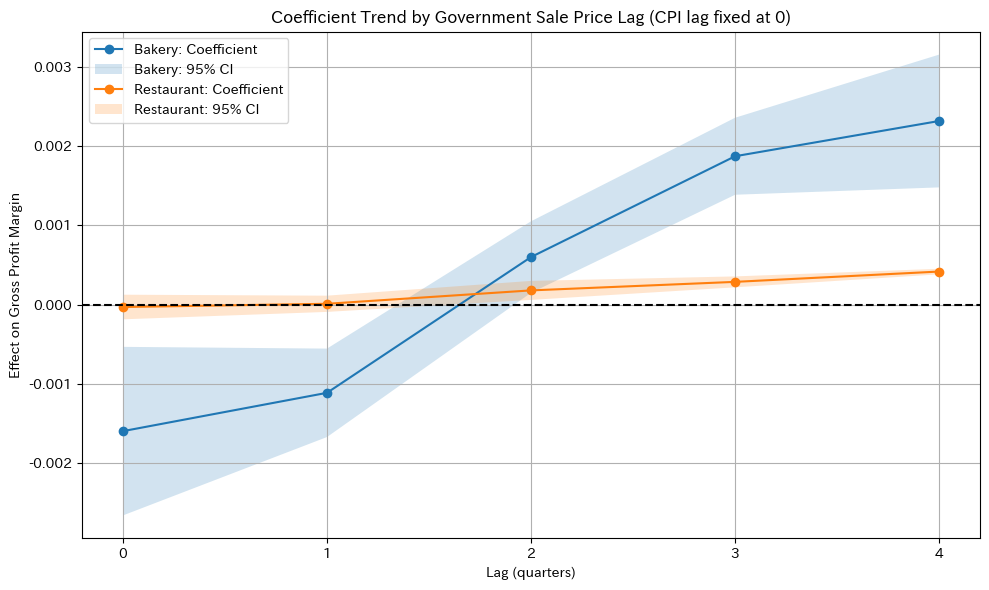

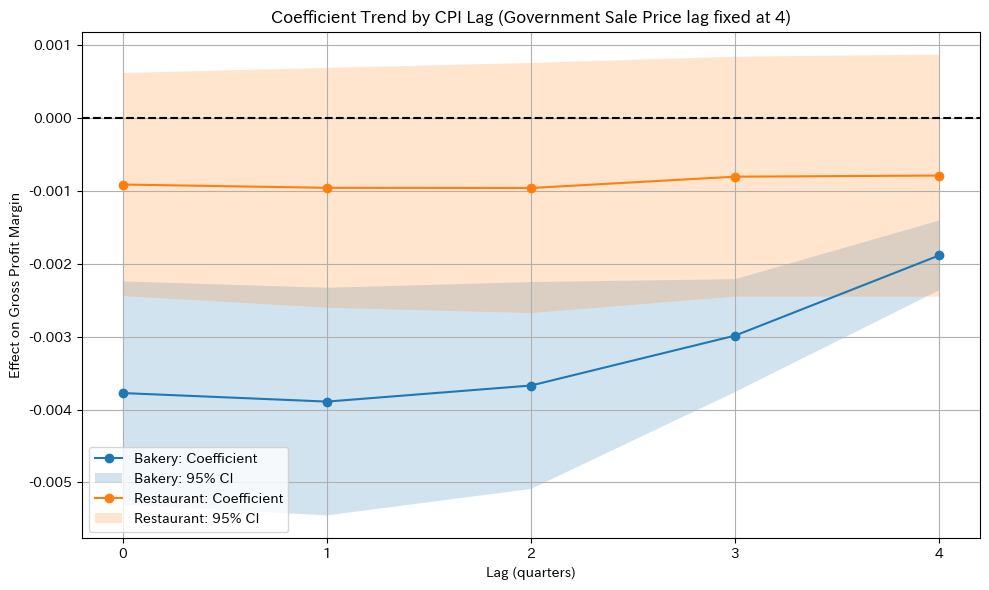

In [11]:
# ======================================================
# 5. Coefficient Trends by Lag (Gov. Sale Price & CPI)
# ======================================================

# --- Industry mapping: Bakery = 0, Restaurant = 1 ---
industry_map = {
    "Yamazaki Baking Co., Ltd.": 0, "Daiichiya Seipan": 0, "Nisshin Seifun Group Inc.": 0,
    "Gyoza no Ohsho": 1, "Toridoll Holdings Corporation": 1, "Skylark Holdings Co., Ltd.": 1
}
df["Industry"] = df["Company Name"].map(industry_map)

lags = [0, 1, 2, 3, 4]

# ======================================================
# 1. Coefficient trend by Government Sale Price lag (CPI lag fixed at 0)
# ======================================================
sector_results_gov = {}

for sector_name, sector_value in {"Bakery": 0, "Restaurant": 1}.items():
    coef_list, ci_lower_list, ci_upper_list = [], [], []
    df_sector = df[df["Industry"] == sector_value].copy()

    for lag in lags:
        col_gov = f"GovPrice_lag{lag}_1000"
        df_sector[col_gov] = (
            df_sector.groupby("Company Name")["Government Sale Price"].shift(lag) / 1000
            if lag != 0 else df_sector["Government Sale Price"] / 1000
        )

        df_sector["CPI_lag0"] = df_sector["CPI"]

        panel = df_sector[[
            "Gross Profit Margin", col_gov, "CPI_lag0", "Company Name", "Quarter_Index"
        ]].dropna().set_index(["Company Name", "Quarter_Index"])

        if panel.empty:
            coef_list.extend([np.nan] * 3)
            continue

        model = PanelOLS.from_formula(
            f"`Gross Profit Margin` ~ `{col_gov}` + `CPI_lag0` + EntityEffects",
            data=panel, check_rank=False
        )
        res = model.fit(cov_type="clustered", cluster_entity=True)

        coef, std = res.params[col_gov], res.std_errors[col_gov]
        coef_list.append(coef)
        ci_lower_list.append(coef - 1.96 * std)
        ci_upper_list.append(coef + 1.96 * std)

    sector_results_gov[sector_name] = {
        "coef": coef_list, "ci_lower": ci_lower_list, "ci_upper": ci_upper_list
    }

# --- Visualization: Government Sale Price Lag Effect ---
plt.figure(figsize=(10, 6))
for sector_name, result in sector_results_gov.items():
    plt.plot(lags, result["coef"], marker='o', label=f'{sector_name}: Coefficient')
    plt.fill_between(lags, result["ci_lower"], result["ci_upper"], alpha=0.2, label=f'{sector_name}: 95% CI')

plt.axhline(0, color='black', linestyle='--')
plt.title("Coefficient Trend by Government Sale Price Lag (CPI lag fixed at 0)")
plt.xlabel("Lag (quarters)")
plt.ylabel("Effect on Gross Profit Margin")
plt.xticks(lags)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("output_gov_price_lag_coeff_trend.png", dpi=300)
plt.show()

# ======================================================
# 2. Coefficient trend by CPI lag (Government Sale Price lag fixed at 4)
# ======================================================
sector_results_cpi = {}

for sector_name, sector_value in {"Bakery": 0, "Restaurant": 1}.items():
    coef_list, ci_lower_list, ci_upper_list = [], [], []
    df_sector = df[df["Industry"] == sector_value].copy()

    for lag in lags:
        col_cpi = f"CPI_lag{lag}"
        df_sector[col_cpi] = (
            df_sector.groupby("Company Name")["CPI"].shift(lag)
            if lag != 0 else df_sector["CPI"]
        )

        df_sector["GovPrice_lag4_1000"] = df_sector.groupby("Company Name")["Government Sale Price"].shift(4) / 1000

        panel = df_sector[[
            "Gross Profit Margin", "GovPrice_lag4_1000", col_cpi, "Company Name", "Quarter_Index"
        ]].dropna().set_index(["Company Name", "Quarter_Index"])

        if panel.empty:
            coef_list.extend([np.nan] * 3)
            continue

        model = PanelOLS.from_formula(
            f"`Gross Profit Margin` ~ `GovPrice_lag4_1000` + `{col_cpi}` + EntityEffects",
            data=panel, check_rank=False
        )
        res = model.fit(cov_type="clustered", cluster_entity=True)

        coef, std = res.params[col_cpi], res.std_errors[col_cpi]
        coef_list.append(coef)
        ci_lower_list.append(coef - 1.96 * std)
        ci_upper_list.append(coef + 1.96 * std)

    sector_results_cpi[sector_name] = {
        "coef": coef_list, "ci_lower": ci_lower_list, "ci_upper": ci_upper_list
    }

# --- Visualization: CPI Lag Effect ---
plt.figure(figsize=(10, 6))
for sector_name, result in sector_results_cpi.items():
    plt.plot(lags, result["coef"], marker='o', label=f'{sector_name}: Coefficient')
    plt.fill_between(lags, result["ci_lower"], result["ci_upper"], alpha=0.2, label=f'{sector_name}: 95% CI')

plt.axhline(0, color='black', linestyle='--')
plt.title("Coefficient Trend by CPI Lag (Government Sale Price lag fixed at 4)")
plt.xlabel("Lag (quarters)")
plt.ylabel("Effect on Gross Profit Margin")
plt.xticks(lags)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("output_cpi_lag_coeff_trend.png", dpi=300)
plt.show()


# 4. Coefficient Trends by Lag

## Government Selling Price (GSP)

* **Sensitivity to GSP differs between the bakery and restaurant sectors.**
  (Can Null Hypothesis 2 be rejected?) → Strictly speaking, interaction terms by sector should be included.
* **In the bakery sector, GSP increases initially reduce gross profit margins (lags 0–1),**
  but margins improve thereafter, indicating delayed price pass-through.
* **In the restaurant sector, changes in GSP have a smaller impact**
  on profit margins compared to the bakery sector.

---

## Consumer Price Index (CPI)

* CPI shows an **immediate effect**, followed by gradual recovery.
* The **impact is more pronounced in the bakery sector** than in the restaurant sector.


                           PanelOLS Estimation Summary                           
Dep. Variable:     Gross Profit Margin   R-squared:                        0.7521
Estimator:                    PanelOLS   R-squared (Between):              0.9878
No. Observations:                  216   R-squared (Within):               0.7521
Date:                 Wed, Jun 11 2025   R-squared (Overall):              0.9857
Time:                         05:37:48   Log-likelihood                    686.15
Cov. Estimator:         Driscoll-Kraay                                           
                                         F-statistic:                      103.13
Entities:                            6   P-value                           0.0000
Avg Obs:                        36.000   Distribution:                   F(6,204)
Min Obs:                        36.000                                           
Max Obs:                        36.000   F-statistic (robust):             107.24
                

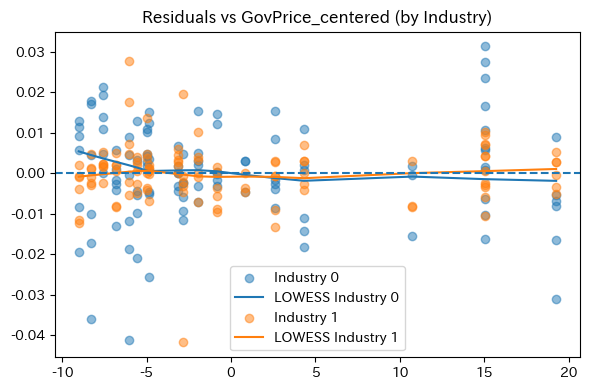

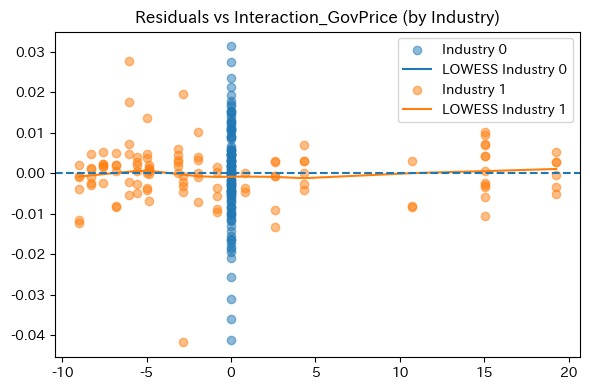

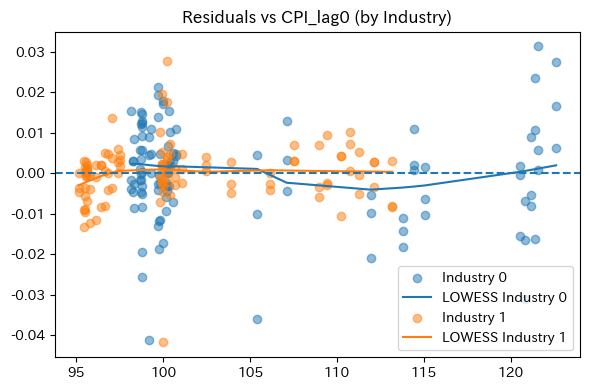

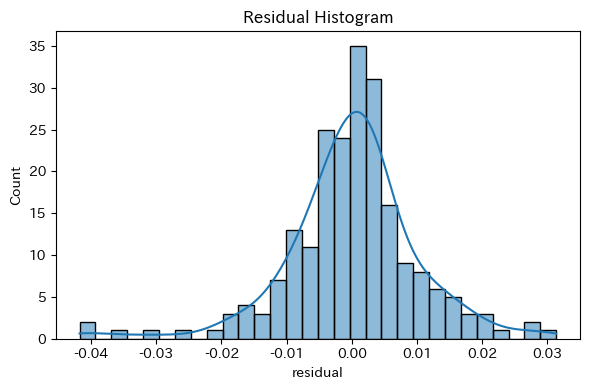

<Figure size 600x300 with 0 Axes>

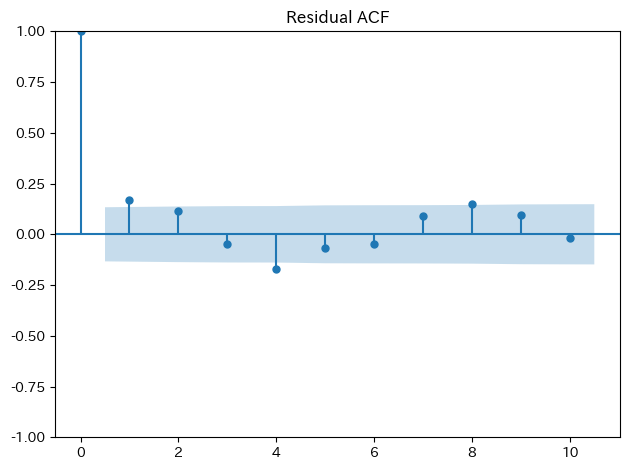

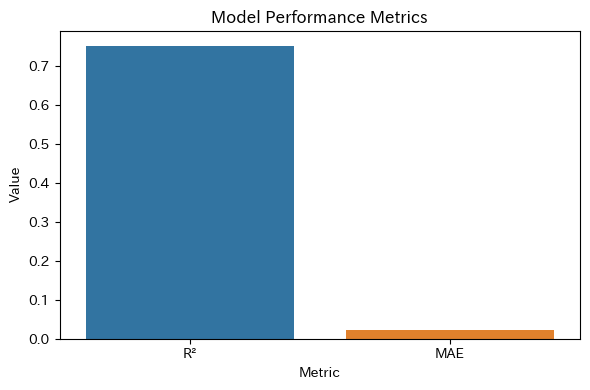

In [12]:
# ======================================================
# 6. Interaction Term Model (with Summary Save)
# ======================================================

warnings.filterwarnings("ignore", category=RuntimeWarning, module="statsmodels")

# --- Industry Mapping ---
industry_map = {
    "Yamazaki Baking Co., Ltd.": 0, "Daiichiya Seipan": 0, "Nisshin Seifun Group Inc.": 0,
    "Gyoza no Ohsho": 1, "Toridoll Holdings Corporation": 1, "Skylark Holdings Co., Ltd.": 1
}
df["Industry"] = df["Company Name"].map(industry_map)

# --- Generate Lags ---
gov_lag, cpi_lag = 4, 0
_df = df.copy()
_df["GPM_lag1"] = _df.groupby("Company Name")["Gross Profit Margin"].shift(1)
_df["GPM_lag4"] = _df.groupby("Company Name")["Gross Profit Margin"].shift(4)
_df[f"GovPrice_lag{gov_lag}_1000"] = _df.groupby("Company Name")["Government Sale Price"].shift(gov_lag) / 1000
_df[f"CPI_lag{cpi_lag}"] = _df.groupby("Company Name")["CPI"].shift(cpi_lag)

# --- PCA on AR Terms ---
valid_idx = _df.dropna(subset=["GPM_lag1", "GPM_lag4"]).index
ar_std = StandardScaler().fit_transform(_df.loc[valid_idx, ["GPM_lag1", "GPM_lag4"]])
ar_pca = PCA(n_components=2).fit_transform(ar_std)
_df.loc[valid_idx, "AR_comp1"] = ar_pca[:, 0]

# --- Spline Expansion ---
spline_basis = dmatrix("bs(AR_comp1, df=3, include_intercept=False)", 
                       data=_df.loc[valid_idx], return_type="dataframe")
spline_basis.columns = [f"AR_spline{i+1}" for i in range(spline_basis.shape[1])]
spline_basis.index = valid_idx
_df = pd.concat([_df, spline_basis], axis=1)

# --- Centering and Interaction Term ---
_df["GovPrice_centered"] = _df[f"GovPrice_lag{gov_lag}_1000"] - _df[f"GovPrice_lag{gov_lag}_1000"].mean()
_df["Industry_Dummy"] = _df["Industry"]
_df["Interaction_GovPrice"] = _df["GovPrice_centered"] * _df["Industry_Dummy"]

# --- Prepare Data ---
predictors = list(spline_basis.columns) + ["GovPrice_centered", "Interaction_GovPrice", f"CPI_lag{cpi_lag}"]
cols = ["Gross Profit Margin"] + predictors + ["Company Name", "Quarter_Index", "Industry"]
panel = _df[cols].dropna().set_index(["Company Name", "Quarter_Index"])

# --- Run Panel Regression ---
formula = f"`Gross Profit Margin` ~ {' + '.join(predictors)} + EntityEffects"
model = PanelOLS.from_formula(formula, panel)
res = model.fit(cov_type="driscoll-kraay")

# --- Save Summary ---
with open("interaction_model_summary.txt", "w", encoding="utf-8") as f:
    f.write(str(res.summary))

print(res.summary)

# --- Model Metrics ---
actual    = panel["Gross Profit Margin"]
fitted    = res.fitted_values.squeeze()
residuals = res.resids.squeeze()
mae = np.mean(np.abs(actual - fitted))
r2  = res.rsquared
dw  = durbin_watson(residuals)
lb_p= acorr_ljungbox(residuals, lags=[10], return_df=True)["lb_pvalue"].iloc[0]
print(f"MAE: {mae:.6f} | R²: {r2:.4f} | DW: {dw:.3f} | LB p={lb_p:.4f}")

# --- VIF ---
vif_X = panel[predictors].copy()
vif_X = sm.add_constant(vif_X, has_constant="add")
vif_df = pd.DataFrame({
    "Variable": vif_X.columns,
    "VIF": [variance_inflation_factor(vif_X.values, i) for i in range(vif_X.shape[1])]
})
vif_df = vif_df[vif_df["Variable"] != "const"]
print("\n[VIF]")
print(vif_df)

# --- Residual Plots by Industry ---
for pred in ["GovPrice_centered", "Interaction_GovPrice", f"CPI_lag{cpi_lag}"]:
    plt.figure(figsize=(6, 4))
    for label, group in panel.groupby("Industry"):
        lw = sm.nonparametric.lowess(residuals[group.index], group[pred])
        plt.scatter(group[pred], residuals[group.index], alpha=0.5, label=f'Industry {label}')
        plt.plot(lw[:, 0], lw[:, 1], label=f'LOWESS Industry {label}')
    plt.axhline(0, linestyle="--")
    plt.title(f"Residuals vs {pred} (by Industry)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"interaction_model_residuals_vs_{pred}_by_industry.png", dpi=300)
    plt.show()
    plt.close()

# --- Residual Histogram ---
plt.figure(figsize=(6, 4))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Residual Histogram")
plt.tight_layout()
plt.savefig("interaction_model_residual_histogram.png", dpi=300)
plt.show()
plt.close()

# --- Residual ACF ---
plt.figure(figsize=(6, 3))
plot_acf(residuals, lags=10)
plt.title("Residual ACF")
plt.tight_layout()
plt.savefig("interaction_model_residual_ACF.png", dpi=300)
plt.show()
plt.close()

# --- Barplot of R² and MAE ---
plt.figure(figsize=(6, 4))
metrics_df = pd.DataFrame({"Metric": ["R²", "MAE"], "Value": [r2, mae]})
sns.barplot(data=metrics_df, x="Metric", y="Value")
plt.title("Model Performance Metrics")
plt.tight_layout()
plt.savefig("interaction_model_metrics_comparison.png", dpi=300)
plt.show()
plt.close()


# 6. Interaction Term Model Results

---

## Model Overview

* **Model Type**: Fixed-effects panel regression (PanelOLS with EntityEffects)
* **Sample Size**: 216 observations (6 companies × 36 quarters)
* **Observation Period**: 36 quarters per company
* **Lags Used**: Government Selling Price = lag 4, CPI = lag 0
* **Spline Degrees of Freedom**: df=3 (based on AR principal components)

---

## Key Model Statistics

| Metric                            | Value    |
| --------------------------------- | -------- |
| R² (Coefficient of Determination) | 0.7521   |
| MAE (Mean Absolute Error)         | 0.023254 |
| DW (Durbin-Watson)                | 1.659    |
| LB Test p-value                   | 0.0030   |
| Model Significance p-value        | 0.0000   |

## Parameter Estimates - Bakery Sector

| Variable              | Coefficient | Std. Error | t-Stat | p-Value | Significance | Interpretation                                   |
| --------------------- | ----------- | ---------- | ------ | ------- | ------------ | ------------------------------------------------ |
| AR\_spline1           | 0.8354      | 0.0348     | 23.981 | 0.0000  | \*\*\*       | Nonlinear lag component effect                   |
| AR\_spline2           | -0.1275     | 0.0359     | -3.553 | 0.0005  | \*\*\*       | Same as above                                    |
| AR\_spline3           | -0.4378     | 0.0810     | -5.405 | 0.0000  | \*\*\*       | Same as above                                    |
| AR\_spline4           | -0.5979     | 0.0720     | -8.302 | 0.0000  | \*\*\*       | Same as above                                    |
| GovPrice\_centered    | 0.0012      | 0.0003     | 4.845  | 0.0000  | \*\*\*       | +0.12pt gross margin per ¥1,000 increase         |
| GovPrice\_interaction | -0.0008     | 0.0003     | -3.083 | 0.0023  | \*\*         | Restaurant sector has lower sensitivity by 0.08% |
| CPI\_lag0             | -0.0006     | 0.0003     | -1.973 | 0.0498  | \*           | -0.06pt gross margin per CPI unit increase       |

* Significance levels: \*\*\*p<0.001, \*\*p<0.01, \*p<0.05

---

## Interpretation Highlights

* **GovPrice\_interaction captures the difference in sensitivity to government price between sectors (p=0.0023)**
* GovPrice\_centered reflects Bakery sector sensitivity, GovPrice\_interaction adjusts for Restaurant sector
* **CPI effect is statistically weak (p=0.0498)**
* **Overall model has strong explanatory power (R² = 0.75)**

---

## About GovPrice\_centered

* **Purpose**: To isolate and compare elasticity of gross margin sensitivity to government wheat prices across sectors.

* **Method**:

  * Centered government price using overall mean: `GovPrice_centered = GovPrice_lag4 - mean(GovPrice_lag4)`

* **Rationale**:

  * Government price levels vary across sectors, skewing interaction terms.
  * Without centering, coefficients combine true sensitivity and mean level differences.

* **Effect of Centering**:

  * Interaction term cleanly reflects slope (sensitivity) difference.
  * Reduces multicollinearity, improving estimate stability.
  * Intercept becomes interpretable: gross margin of Bakery sector at mean government price.

---

## Sector Interaction Comments

* **Government price significantly affects corporate gross margin**, so **Null Hypothesis 1 is rejected**.
* Sensitivity to government price is higher for **Bakery** than **Restaurant** sector.
* Gross margin is strongly influenced by lagged values (AR1 and AR4), suggesting **persistence and seasonality**.
